## Setup

In [ ]:
from random import randint
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets

#def func1(x:float):
#    return x**2-4*x+1

#def gradient_func1(x:float):
#    return 2*x - 4

#def func2(x:float):
#    return 0.01*x**4-3*x**2+5*x+350

#def gradient_func2(x:float):
#    return 0.04*x**3-6*x+5

def random_initialize():
    x = randint(-20, 20)
    y = randint(-20,20)
    return np.meshgrid(x,y)

#def build_function1():
#    x = np.arange(-20., 20., 0.2)
#    y = np.array([func1(val) for val in x])
#    return x,y, func1, gradient_func1

#def build_function2():
#    x = np.arange(-20., 20., 0.2)
#    y = np.array([func2(val) for val in x])
#    return x,y, func2, gradient_func2

def build_function1():
    def f(x, y):
        # Scale the coefficients to increase the depth and curvature differences
        return 0.3 * (x - 10)**2 + 0.2 * (y - 10)**2 + 1 * (x + 10)**2 + 1 * (y + 10)**2

    def grad(x, y):
        # Adjusted gradient for the scaled function
        grad_x = 0.6 * (x - 10) + 2 * (x + 10)  # Increased coefficients for the gradients
        grad_y = 0.4 * (y - 10) + 2 * (y + 10)
        return np.array([grad_x, grad_y])

    x = np.linspace(-20, 20, 400)
    y = np.linspace(-20, 20, 400)
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    return X, Y, Z, f, grad

def build_function3():
    def f(x, y):
        return x**2+y**2  # Z as a function of X and Y
    def grad(x, y):
        grad_x = 2*x
        grad_y = 2*y
        return np.array([grad_x, grad_y])
    x = np.linspace(-20, 20, 100)
    y = np.linspace(-20, 20, 100)
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    return X, Y, Z, f, grad

def build_output(method='gradient'):

    lr_slider = widgets.FloatSlider(
        value=0.1, min=0, max=2, step=0.01, 
        description="Learning Rate",
        style={'description_width': 'initial'},  # Ensure description does not get cut off
        layout=widgets.Layout(width='100%')  # Full width of the container
    )

    steps_slider = widgets.IntSlider(
        value=10, min=1, max=30, step=1, 
        description="Steps",
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='100%')
    )

    func_dropdown = widgets.Dropdown(
        description="Function", 
        options=[('simple Function', build_function3), ('complex Function', build_function1)],  # Use a list of tuples for clarity
        layout=widgets.Layout(width='50%')  # Adjust as needed based on UI considerations
    )

    x_slider = widgets.IntSlider(
        value=0, min=-20, max=20, step=1, 
        description="Starting X",
        layout=widgets.Layout(width='50%')
    )

    y_slider = widgets.IntSlider(
        value=0, min=-20, max=20, step=1, 
        description="Starting Y",
        layout=widgets.Layout(width='50%')
    )

    beta_slider = widgets.FloatSlider(
        value=0, min=-0, max=1, step=0.01, 
        description="Beta Factor",
        layout=widgets.Layout(width='50%')
    )

    # Create a horizontal box to hold the widgets


    match method:
        case 'gradient':
            ui = widgets.HBox([x_slider, y_slider, lr_slider, steps_slider, func_dropdown], 
                layout=widgets.Layout(flex_flow='row wrap'))  # Wrap the content if not enough space
                
            out = widgets.interactive_output(gradient_descent, {
            'initialX': x_slider, 'initialY': y_slider, 'lr': lr_slider, 
            'steps': steps_slider, 'function': func_dropdown,
            'print_res': widgets.fixed(False), 'initialRandom': widgets.fixed(False)
            })
        case 'momentum':
            ui = widgets.HBox([x_slider, y_slider, lr_slider, steps_slider,beta_slider, func_dropdown], 
                layout=widgets.Layout(flex_flow='row wrap'))  # Wrap the content if not enough space
            out = widgets.interactive_output(momentum_gradient_descent, {
            'initialX': x_slider, 'initialY': y_slider, 'lr': lr_slider, 
            'steps': steps_slider, 'function': func_dropdown,
            'beta': beta_slider,
            'print_res': widgets.fixed(False), 'initialRandom': widgets.fixed(False)
            })
        case 'nesterov':
            ui = widgets.HBox([x_slider, y_slider, lr_slider, steps_slider,beta_slider, func_dropdown], 
                layout=widgets.Layout(flex_flow='row wrap'))  # Wrap the content if not enough space
            out = widgets.interactive_output(nesterov_gradient_descent, {
            'initialX': x_slider, 'initialY': y_slider, 'lr': lr_slider, 
            'steps': steps_slider, 'function': func_dropdown,
            'beta': beta_slider,
            'print_res': widgets.fixed(False), 'initialRandom': widgets.fixed(False)
            })
        case 'adagrad':
            ui = widgets.HBox([x_slider, y_slider, lr_slider, steps_slider,func_dropdown], 
                layout=widgets.Layout(flex_flow='row wrap'))  # Wrap the content if not enough space
            out = widgets.interactive_output(adagrad_gradient_descent, {
            'initialX': x_slider, 'initialY': y_slider, 'lr': lr_slider, 
            'steps': steps_slider, 'function': func_dropdown,
            'print_res': widgets.fixed(False), 'initialRandom': widgets.fixed(False)
            })
    
    display(ui, out)


## Regular Gradient Descent

$$
\theta \leftarrow \theta - \eta \nabla_{\theta} J(\theta)
$$

In [ ]:
def step(pos, r, grad):
    pos = pos - r * grad(*pos)  
    return pos

def gradient_descent(function=build_function3, steps=1, lr=0.1, print_res=False, initialRandom=False, initialX=10, initialY=10):
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(12, 8))
    X, Y, Z, f, grad = function()
    ax.plot_surface(X, Y, Z, alpha=0.5, cmap='viridis')
    
    if initialRandom:
        cur_pos = random_initialize()
    else:
        cur_pos = np.array([initialX, initialY])  

    for i in range(steps):
        cur_z = f(cur_pos[0], cur_pos[1])
        ax.plot(cur_pos[0], cur_pos[1], cur_z, color="red",marker="o")
        cur_pos = step(cur_pos, lr, grad)
        if print_res:
            print(f"Step {i}: X, Y = {cur_pos}, Z = {cur_z}")
    ax.set_xlim((-20,20))
    ax.set_ylim((-20,20))
    ax.set_zlim((-20,1000))
    
    plt.show()

build_output(method='gradient')

Output()

## Momentum Optimization

$$
m \leftarrow \beta m - \eta \nabla_{\theta} J(\theta) \\
\theta \leftarrow \theta + m
$$

In [ ]:
def momentum_step(pos, lr, beta, momentum, grad):
    gradient = grad(*pos)
    momentum = beta * momentum - lr * gradient
    pos = pos + momentum

    return momentum, pos

def momentum_gradient_descent(function=build_function3, steps=10, lr=0.1, beta=0.1, print_res=False, initialRandom=True, initialX=10, initialY=10):
    X, Y, Z, f, grad = function()
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(12, 8))
    ax.plot_surface(X, Y, Z, alpha=0.5, cmap='viridis')

    if initialRandom:
        cur_pos = random_initialize()
    else:
        cur_pos = np.array([initialX, initialY])  # Starting position as a 2D vector

    momentum = np.zeros(2)  # Momentum as a vector
    for i in range(steps):
        cur_z = f(cur_pos[0], cur_pos[1])
        ax.scatter(cur_pos[0], cur_pos[1], cur_z, color='red', marker='o')
        momentum, cur_pos = momentum_step(cur_pos, lr, beta, momentum, grad)
        if print_res:
            print(f"Step {i}: X = {cur_pos[0]}, Y = {cur_pos[1]}, Z = {cur_z}")

build_output(method='momentum')



Output()

## Comparision

Regular Gradient-Descent


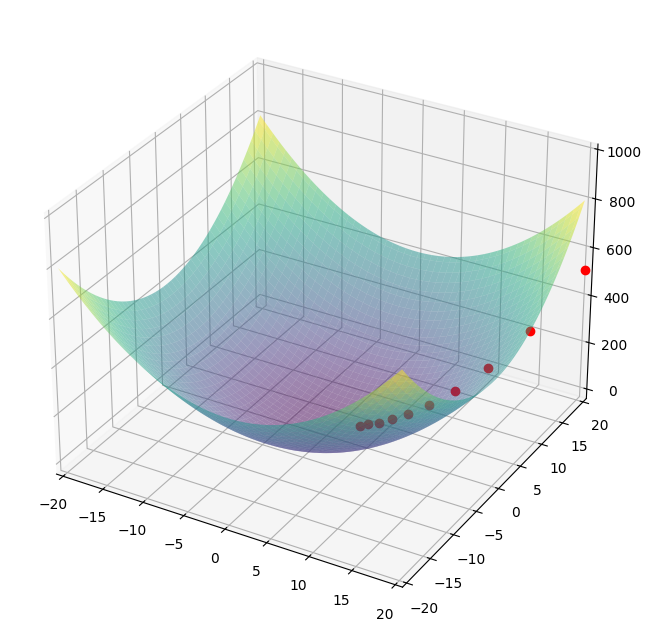

Momentum Optimization


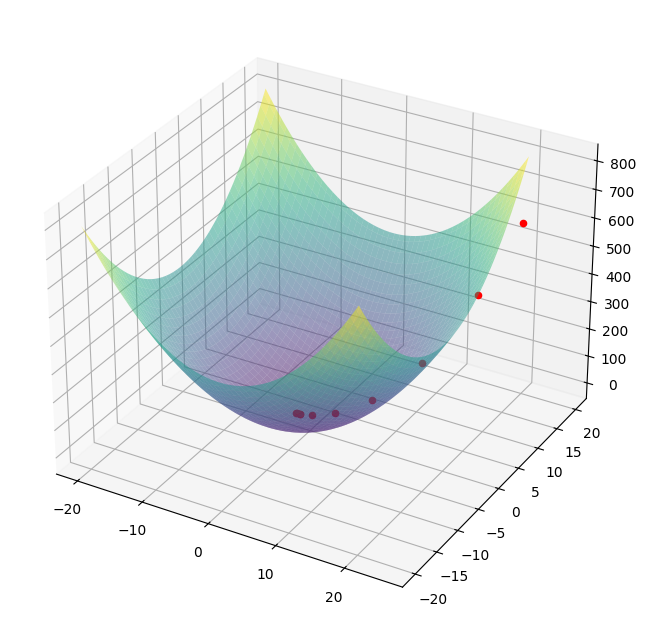

In [ ]:
print("Regular Gradient-Descent")
gradient_descent(steps=10, initialRandom=False, initialX=25, print_res=False)
print("Momentum Optimization")
momentum_gradient_descent(steps=10,beta=0.5, initialRandom=False, initialX=25, print_res=False)


## Nesterov Accelerated Gradient

$$ m \leftarrow \beta m - \eta \nabla_{\theta} J(\theta + \beta m) $$
$$ \theta \leftarrow \theta + m $$

In [ ]:
def nesterov_step(pos, lr, beta, momentum, grad):
    lookahead_pos = pos + beta * momentum #Use the gradient slightly ahead in the direction of the momentum
    gradient = grad(*lookahead_pos)
    momentum = beta * momentum - lr * gradient
    pos = pos + momentum
    
    return momentum, pos

def nesterov_gradient_descent(function=build_function3, steps=10, lr=0.1, beta=0.1, print_res=False, initialRandom=True, initialX=10, initialY=10):
    X, Y, Z, f, grad = function()
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(12, 8))
    ax.plot_surface(X, Y, Z, alpha=0.5, cmap='viridis')

    if initialRandom:
        cur_pos = random_initialize()
    else:
        cur_pos = np.array([initialX, initialY])  # Starting position as a 2D vector

    momentum = np.zeros(2)  # Momentum as a vector
    for i in range(steps):
        cur_z = f(cur_pos[0], cur_pos[1])
        ax.scatter(cur_pos[0], cur_pos[1], cur_z, color='red', marker='o')
        momentum, cur_pos = nesterov_step(cur_pos, lr, beta, momentum, grad)
        if print_res:
            print(f"Step {i}: X = {cur_pos[0]}, Y = {cur_pos[1]}, Z = {cur_z}")

build_output(method='nesterov')

Output()

## AdaGrad

$$ s \leftarrow s + \nabla_{\theta} J(\theta)^2 $$
$$ \theta \leftarrow \theta - \frac{\eta}{\sqrt{s + \epsilon}} \cdot \nabla_{\theta} J(\theta)  $$

In [ ]:
def adagrad_step(pos, lr, grad, s):
    epsilon = 10**(-10) #set to different value if needed
    gradient = grad(*pos)
    s = s + gradient ** 2  # Accumulate squared gradients
    adjusted_lr = lr / (np.sqrt(s) + epsilon)
    pos = pos - adjusted_lr * gradient
    
    return pos, s

def adagrad_gradient_descent(function=build_function3, steps=10, lr=0.1, print_res=False, initialRandom=True, initialX=10, initialY=10):
    X, Y, Z, f, grad = function()
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(12, 8))
    ax.plot_surface(X, Y, Z, alpha=0.5, cmap='viridis')

    if initialRandom:
        cur_pos = random_initialize()
    else:
        cur_pos = np.array([initialX, initialY])  # Starting position as a 2D vector

    s = 0
    for i in range(steps):
        cur_z = f(cur_pos[0], cur_pos[1])
        ax.scatter(cur_pos[0], cur_pos[1], cur_z, color='red', marker='o')
        cur_pos, s = adagrad_step(cur_pos, lr, grad, s)
        if print_res:
            print(f"Step {i}: X = {cur_pos[0]}, Y = {cur_pos[1]}, Z = {cur_z}")

build_output(method='adagrad')

Output()

In [20]:
import math
from random import randint
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets

In [21]:
def random_initialize():
    x = randint(-20, 20)
    y = randint(-20, 20)
    return np.meshgrid(x, y)


def steep_valley_function():
    def f(x, y):
        # Define a function with a steeper gradient in the y-direction
        return 0.5 * x**2 + 2 * y**2

    def grad(x, y):
        # Compute the gradient of the function
        grad_x = x  # Gradient with respect to x
        grad_y = 4 * y  # Gradient with respect to y, steeper than x
        return np.array([grad_x, grad_y])

    x = np.linspace(-20, 20, 400)
    y = np.linspace(-20, 20, 400)
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    return X, Y, Z, f, grad


def l_shaped_valley_function():
    def f(x, y):
        # Creating an L-shaped valley with a sharp turn
        # Define the valley with two different linear regions
        # Horizontal part (x > y), Vertical part (x <= y)
        return np.where(x > y, (y + 20) ** 2 + x, (x + 20) ** 2 + y)

    def grad(x, y):
        # Gradient of the L-shaped function, changing at x = y
        # Horizontal part gradient
        grad_x = np.where(x > y, 1, 2 * (x + 20))
        grad_y = np.where(x > y, 2 * (y + 20), 1)
        return np.array([grad_x, grad_y])

    x = np.linspace(-50, 20, 400)
    y = np.linspace(-50, 20, 400)
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    return X, Y, Z, f, grad


def complex_function():
    def f(x, y):
        # Scale the coefficients to increase the depth and curvature differences
        return (
            0.3 * (x - 10) ** 2
            + 0.2 * (y - 10) ** 2
            + 1 * (x + 10) ** 2
            + 1 * (y + 10) ** 2
        )

    def grad(x, y):
        # Adjusted gradient for the scaled function
        grad_x = 0.6 * (x - 10) + 2 * (
            x + 10
        )  # Increased coefficients for the gradients
        grad_y = 0.4 * (y - 10) + 2 * (y + 10)
        return np.array([grad_x, grad_y])

    x = np.linspace(-20, 20, 400)
    y = np.linspace(-20, 20, 400)
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    return X, Y, Z, f, grad


def simple_function():
    def f(x, y):
        return x**2 + y**2  # Z as a function of X and Y

    def grad(x, y):
        grad_x = 2 * x
        grad_y = 2 * y
        return np.array([grad_x, grad_y])

    x = np.linspace(-20, 20, 100)
    y = np.linspace(-20, 20, 100)
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    return X, Y, Z, f, grad


def build_output(method="gradient"):

    lr_slider = widgets.FloatSlider(
        value=0.1,
        min=0,
        max=2,
        step=0.01,
        description="Learning Rate",
        style={
            "description_width": "initial"
        },  # Ensure description does not get cut off
        layout=widgets.Layout(width="100%"),  # Full width of the container
    )

    steps_slider = widgets.IntSlider(
        value=10,
        min=1,
        max=30,
        step=1,
        description="Steps",
        style={"description_width": "initial"},
        layout=widgets.Layout(width="100%"),
    )

    func_dropdown = widgets.Dropdown(
        description="Function",
        options=[
            ("simple Function", simple_function),
            ("complex Function", complex_function),
            ("L-shaped Valley Function", l_shaped_valley_function),
            ("Steep Valley Function", steep_valley_function),
        ],  # Use a list of tuples for clarity
        layout=widgets.Layout(
            width="50%"
        ),  # Adjust as needed based on UI considerations
    )

    x_slider = widgets.IntSlider(
        value=15,
        min=-20,
        max=20,
        step=1,
        description="Starting X",
        layout=widgets.Layout(width="50%"),
    )

    y_slider = widgets.IntSlider(
        value=10,
        min=-20,
        max=20,
        step=1,
        description="Starting Y",
        layout=widgets.Layout(width="50%"),
    )

    beta_slider = widgets.FloatSlider(
        value=0.9,
        min=-0,
        max=1,
        step=0.01,
        description="Beta Factor",
        layout=widgets.Layout(width="50%"),
    )

    # Create a horizontal box to hold the widgets

    match method:
        case "gradient":
            ui = widgets.HBox(
                [x_slider, y_slider, lr_slider, steps_slider, func_dropdown],
                layout=widgets.Layout(flex_flow="row wrap"),
            )  # Wrap the content if not enough space

            out = widgets.interactive_output(
                regular_gradient_descent,
                {
                    "initialX": x_slider,
                    "initialY": y_slider,
                    "lr": lr_slider,
                    "steps": steps_slider,
                    "function": func_dropdown,
                    "print_res": widgets.fixed(False),
                    "initialRandom": widgets.fixed(False),
                },
            )
        case "momentum":
            ui = widgets.HBox(
                [
                    x_slider,
                    y_slider,
                    lr_slider,
                    steps_slider,
                    beta_slider,
                    func_dropdown,
                ],
                layout=widgets.Layout(flex_flow="row wrap"),
            )  # Wrap the content if not enough space
            out = widgets.interactive_output(
                momentum_gradient_descent,
                {
                    "initialX": x_slider,
                    "initialY": y_slider,
                    "lr": lr_slider,
                    "steps": steps_slider,
                    "function": func_dropdown,
                    "beta": beta_slider,
                    "print_res": widgets.fixed(False),
                    "initialRandom": widgets.fixed(False),
                },
            )
        case "nesterov":
            ui = widgets.HBox(
                [
                    x_slider,
                    y_slider,
                    lr_slider,
                    steps_slider,
                    beta_slider,
                    func_dropdown,
                ],
                layout=widgets.Layout(flex_flow="row wrap"),
            )  # Wrap the content if not enough space
            out = widgets.interactive_output(
                nesterov_gradient_descent,
                {
                    "initialX": x_slider,
                    "initialY": y_slider,
                    "lr": lr_slider,
                    "steps": steps_slider,
                    "function": func_dropdown,
                    "beta": beta_slider,
                    "print_res": widgets.fixed(False),
                    "initialRandom": widgets.fixed(False),
                },
            )
        case "adagrad":
            ui = widgets.HBox(
                [x_slider, y_slider, lr_slider, steps_slider, func_dropdown],
                layout=widgets.Layout(flex_flow="row wrap"),
            )  # Wrap the content if not enough space
            out = widgets.interactive_output(
                adagrad_gradient_descent,
                {
                    "initialX": x_slider,
                    "initialY": y_slider,
                    "lr": lr_slider,
                    "steps": steps_slider,
                    "function": func_dropdown,
                    "print_res": widgets.fixed(False),
                    "initialRandom": widgets.fixed(False),
                },
            )
        case "rmsprop":
            ui = widgets.HBox(
                [
                    x_slider,
                    y_slider,
                    lr_slider,
                    steps_slider,
                    beta_slider,
                    func_dropdown,
                ],
                layout=widgets.Layout(flex_flow="row wrap"),
            )  # Arrange widgets in a row, wrap if space is insufficient

            out = widgets.interactive_output(
                rmsprop_gradient_descent,
                {
                    "initialX": x_slider,
                    "initialY": y_slider,
                    "lr": lr_slider,
                    "steps": steps_slider,
                    "beta": beta_slider,
                    "function": func_dropdown,
                    "print_res": widgets.fixed(False),
                    "initialRandom": widgets.fixed(False),
                },
            )
        case "adam":
            ui = widgets.HBox(
                [x_slider, y_slider, lr_slider, steps_slider, func_dropdown],
                layout=widgets.Layout(flex_flow="row wrap"),
            )
            out = widgets.interactive_output(
                adam_gradient_descent,
                {
                    "initialX": x_slider,
                    "initialY": y_slider,
                    "lr": lr_slider,
                    "steps": steps_slider,
                    "function": func_dropdown,
                    "print_res": widgets.fixed(False),
                    "initialRandom": widgets.fixed(False),
                },
            )

    display(ui, out)

In [22]:
def plot_optimization_path(X, Y, Z, positions, function, function_name):
    fig = plt.figure(figsize=(24, 8))
    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax2 = fig.add_subplot(1, 2, 2)  # 2D plot for top-down heatmap view

    # Plot the 3D surface
    ax1.plot_surface(X, Y, Z, alpha=0.5, cmap="viridis", edgecolor="none")
    ax1.set_title("3D View - " + function_name)

    # Convert positions to an array for easier manipulation
    positions_array = np.array(positions)
    # Calculate Z values for each X, Y position
    z_values = np.array([function(pos[0], pos[1]) for pos in positions_array])

    # Plotting the path on the 3D plot
    ax1.scatter(
        positions_array[:, 0], positions_array[:, 1], z_values, color="red", s=50
    )

    # Create a contour plot for the 2D view
    ax2.contourf(X, Y, Z, levels=100, cmap="viridis")
    ax2.plot(
        positions_array[:, 0],
        positions_array[:, 1],
        marker="o",
        color="red",
        markersize=5,
        linestyle="--",
        linewidth=2,
    )
    ax2.set_title("Top-Down View (2D) - " + function_name)
    ax2.set_xlabel("X")
    ax2.set_ylabel("Y")

    # Show the plot
    plt.show()

## Regular Gradient Descent

$$
\theta \leftarrow \theta - \eta \nabla_{\theta} J(\theta)
$$

In [23]:
def regular_gradient_step(pos, lr, grad):
    return pos - lr * grad(*pos)


def regular_gradient_descent(
    function=steep_valley_function,
    steps=1,
    lr=0.1,
    print_res=False,
    initialRandom=False,
    initialX=0,
    initialY=0,
):
    X, Y, Z, f, grad = function()
    cur_pos = np.array([initialX, initialY])
    positions = [cur_pos]

    for i in range(steps):
        cur_pos = regular_gradient_step(cur_pos, lr, grad)
        positions.append(cur_pos)
        if print_res:
            cur_z = f(cur_pos[0], cur_pos[1])
            print(f"Step {i}: X, Y = {cur_pos}, Z = {cur_z}")

    plot_optimization_path(X, Y, Z, positions, f, "Regular Gradient Descent")


build_output(method="gradient")

Output()

## Momentum Optimization

$$
m \leftarrow \beta m - \eta \nabla_{\theta} J(\theta) \\
\theta \leftarrow \theta + m
$$

In [5]:
def momentum_step(pos, lr, beta, momentum, grad):
    gradient = grad(*pos)
    momentum = beta * momentum - lr * gradient
    pos = pos + momentum

    return momentum, pos


def momentum_gradient_descent(
    function=simple_function,
    steps=10,
    lr=0.1,
    beta=0.1,
    print_res=False,
    initialRandom=True,
    initialX=10,
    initialY=10,
):
    X, Y, Z, f, grad = function()
    cur_pos = random_initialize() if initialRandom else np.array([initialX, initialY])
    momentum = np.zeros(2)
    positions = [cur_pos]

    for i in range(steps):
        momentum, cur_pos = momentum_step(cur_pos, lr, beta, momentum, grad)
        positions.append(cur_pos)
        if print_res:
            print(f"Step {i}: X = {cur_pos[0]}, Y = {cur_pos[1]}")

    plot_optimization_path(X, Y, Z, positions, f, "Momentum Gradient Descent")


build_output(method="momentum")

Output()

## Comparision

In [ ]:
# doesn't yet work with new plot function
# print("Regular Gradient-Descent")
# regular_gradient_descent(steps=10, initialRandom=False, initialX=25, print_res=False)
# print("Momentum Optimization")
# momentum_gradient_descent(steps=10,beta=0.5, initialRandom=False, initialX=25, print_res=False)

## Nesterov Accelerated Gradient

$$ m \leftarrow \beta m - \eta \nabla_{\theta} J(\theta + \beta m) $$
$$ \theta \leftarrow \theta + m $$

In [6]:
def nesterov_step(pos, lr, beta, momentum, grad):
    lookahead_pos = (
        pos + beta * momentum
    )  # Use the gradient slightly ahead in the direction of the momentum
    gradient = grad(*lookahead_pos)
    momentum = beta * momentum - lr * gradient
    pos = pos + momentum

    return momentum, pos


def nesterov_gradient_descent(
    function=steep_valley_function,
    steps=10,
    lr=0.1,
    beta=0.1,
    print_res=False,
    initialRandom=False,
    initialX=10,
    initialY=10,
):
    X, Y, Z, f, grad = function()
    if initialRandom:
        cur_pos = random_initialize()
    else:
        cur_pos = np.array([initialX, initialY])  # Starting position as a 2D vector

    momentum = np.zeros(2)  # Initial momentum vector
    positions = [cur_pos.copy()]  # List to store positions for plotting

    for i in range(steps):
        momentum, cur_pos = nesterov_step(cur_pos, lr, beta, momentum, grad)
        positions.append(cur_pos.copy())  # Append the new position after update
        if print_res:
            cur_z = f(cur_pos[0], cur_pos[1])
            print(f"Step {i}: X = {cur_pos[0]}, Y = {cur_pos[1]}, Z = {cur_z}")

    # Use the generic plotting function to visualize the path
    plot_optimization_path(X, Y, Z, positions, f, "Nesterov Gradient Descent")


build_output(method="nesterov")

Output()

## AdaGrad

$$ \mathbf{s} \leftarrow \mathbf{s} + \nabla_{\theta} J(\theta) \otimes \nabla_{\theta} J(\theta) $$
$$ \theta \leftarrow \theta - \eta  \nabla_{\theta} J(\theta) \oslash \sqrt{\mathbf{s} + \epsilon} $$

In [7]:
def adagrad_step(pos, lr, grad, s):
    epsilon = 10 ** (-10)  # set to different value if needed
    gradient = grad(*pos)
    s = s + gradient**2  # Accumulate squared gradients
    adjusted_lr = lr / (np.sqrt(s) + epsilon)
    pos = pos - adjusted_lr * gradient

    return pos, s


def adagrad_gradient_descent(
    function=simple_function,
    steps=10,
    lr=0.1,
    print_res=False,
    initialRandom=True,
    initialX=10,
    initialY=10,
):
    X, Y, Z, f, grad = function()
    if initialRandom:
        cur_pos = random_initialize()
    else:
        cur_pos = np.array([initialX, initialY])  # Starting position as a 2D vector

    s = np.zeros(2)  # Initialize sum of squares of gradients
    positions = [cur_pos.copy()]  # Store positions for plotting

    for i in range(steps):
        cur_pos, s = adagrad_step(cur_pos, lr, grad, s)
        positions.append(cur_pos.copy())  # Append the new position after update
        if print_res:
            cur_z = f(cur_pos[0], cur_pos[1])
            print(f"Step {i}: X = {cur_pos[0]}, Y = {cur_pos[1]}, Z = {cur_z}")

    # Use the generic plotting function to visualize the path
    plot_optimization_path(X, Y, Z, positions, f, "AdaGrad Gradient Descent")


build_output(method="adagrad")

Output()

## RMSProp

$$ \mathbf{s} \leftarrow \beta \mathbf{s} + (1-\beta) \nabla_{\theta} J(\theta) \otimes \nabla_{\theta} J(\theta) $$
$$ \theta \leftarrow \theta - \eta \nabla_{\theta} J(\theta) \oslash \sqrt{\mathbf{s} + \epsilon} $$

In [8]:
def rmsprop_step(pos, lr, grad, s, beta=0.9, epsilon=1e-8):
    # Compute the gradient at the current position
    gradient = grad(*pos)

    # Update the moving average of the squared gradients
    s = beta * s + (1 - beta) * gradient * gradient  # gradient**2 also possible

    pos = pos - (lr * gradient / (np.sqrt(s + epsilon)))

    return pos, s

    # # alternative function with adjusted learning rate
    # gradient = grad(*pos)
    # s = beta * s + (1 - beta) * gradient ** 2  # Update accumulation of squared gradients
    # adjusted_lr = lr / (np.sqrt(s) + epsilon)  # Adjust learning rate
    # pos = pos - adjusted_lr * gradient  # Update position
    # return pos, s


def rmsprop_gradient_descent(
    function=simple_function,
    steps=10,
    lr=0.1,
    beta=0.9,
    print_res=False,
    initialRandom=True,
    initialX=10,
    initialY=10,
):
    X, Y, Z, f, grad = function()  # Load the function's landscape and gradient
    if initialRandom:
        # If random initialization is specified
        cur_pos = np.array([random.randint(-20, 20), random.randint(-20, 20)])
    else:
        cur_pos = np.array([initialX, initialY])  # Use the specified initial position

    s = np.zeros_like(cur_pos)  # Initialize the RMS accumulation variable
    positions = [cur_pos.copy()]  # List to collect all positions for visualization

    for i in range(steps):
        cur_pos, s = rmsprop_step(cur_pos, lr, grad, s, beta)  # Update position and RMS
        positions.append(cur_pos.copy())  # Append the new position for plotting
        if print_res:
            cur_z = f(*cur_pos)
            print(f"Step {i}: X = {cur_pos[0]}, Y = {cur_pos[1]}, Z = {cur_z}")

    # Call the plot function at the end of all iterations
    plot_optimization_path(X, Y, Z, positions, f, "RMSProp Gradient Descent")


build_output(method="rmsprop")

Output()

## Adam

$$ \mathbf{m} \leftarrow \beta_1 \mathbf{m} + (1 - \beta_1) \nabla_{\theta} J(\theta) $$
$$ \mathbf{s} \leftarrow \beta_2 \mathbf{s} + (1 - \beta_2) \nabla_{\theta} J(\theta) \otimes \nabla_{\theta} J(\theta) $$
$$ \widehat{\mathbf{m}} \leftarrow \frac{\mathbf{m}}{1 - \beta_1^t}, \quad \widehat{\mathbf{s}} \leftarrow \frac{\mathbf{s}}{1 - \beta_2^t} $$
$$ \theta \leftarrow \theta - \eta \widehat{\mathbf{m}} \oslash \sqrt{\widehat{\mathbf{s}} + \epsilon} $$

In [9]:
def adam_step(pos, lr, grad, m, v, t, beta1=0.9, beta2=0.999, epsilon=1e-8):
    gradient = grad(*pos)
    m = beta1 * m + (1 - beta1) * gradient  # Update biased first moment estimate
    v = beta2 * v + (1 - beta2) * gradient**2  # Update biased second moment estimate
    m_hat = m / (1 - beta1**t)  # Compute bias-corrected first moment estimate
    v_hat = v / (1 - beta2**t)  # Compute bias-corrected second moment estimate
    pos = pos - lr * m_hat / (np.sqrt(v_hat) + epsilon)  # Update parameters
    return pos, m, v


def adam_gradient_descent(
    function=simple_function,
    steps=10,
    lr=0.1,
    print_res=False,
    initialRandom=True,
    initialX=10,
    initialY=10,
):
    X, Y, Z, f, grad = function()
    if initialRandom:
        cur_pos = np.array([np.random.randint(-20, 20), np.random.randint(-20, 20)])
    else:
        cur_pos = np.array([initialX, initialY])

    m = np.zeros_like(cur_pos)  # Initialize first moment vector
    v = np.zeros_like(cur_pos)  # Initialize second moment vector
    t = 0  # Initialize timestep

    positions = [cur_pos.copy()]  # Store positions for plotting

    for i in range(1, steps + 1):
        t += 1  # Increment time step
        cur_pos, m, v = adam_step(cur_pos, lr, grad, m, v, t)  # Adam optimization step
        positions.append(cur_pos.copy())
        if print_res:
            cur_z = f(*cur_pos)
            print(f"Step {i}: X = {cur_pos[0]}, Y = {cur_pos[1]}, Z = {cur_z}")

    # Use the plot function to visualize the optimization path
    plot_optimization_path(X, Y, Z, positions, f, "Adam Gradient Descent")


build_output(method="adam")

Output()